### Imports

In [20]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import datetime as dt
import difflib
from fuzzywuzzy import process
from wordcloud import WordCloud

### Generating all dates (common processing step for visualization)

In [2]:
def get_dates(mode='month'):
    dates = []
    for year in range(2016, 2021):
        for month in range(1, 13):
            if month > 4 and year == 2020:
                break
            dates.append(dt.datetime(year=year, month=month, day=1))
    return dates
dates = get_dates()

## Sentiment Plot 
### Preprocessing (Run Once)

In [10]:
def sentiment_plot(year):
    """ Get Sentiment Average and Total for a year """

    df = pd.read_csv("news-{}.csv".format(year))
    group = df.groupby(['month']).agg({'sentiment-svm': ['mean', 'sum']})
    group.columns = ['mean_sentiment', 'sum_sentiment']
    group = group.reset_index()
    return group['mean_sentiment'].values, group['sum_sentiment'].values

# Get monthly sentiment Average and Total in each year
means = np.zeros(52)
summation = np.zeros(52)
for i in range(2016, 2021):
    mean, tot = sentiment_plot(i)
    means[12*(i-2016): min(52, 12*(i-2016+1))] = mean
    summation[12*(i-2016): min(52, 12*(i-2016+1))] = tot
np.save("svm-mean.npy", means)
np.save("svm-summation.npy", summation)

[0 0 1 ... 1 1 0]


/Users/ahmedtawfik/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


[0 0 1 ... 0 0 1]
[0 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
[1 1 0 ... 1 1 1]


### Plotting

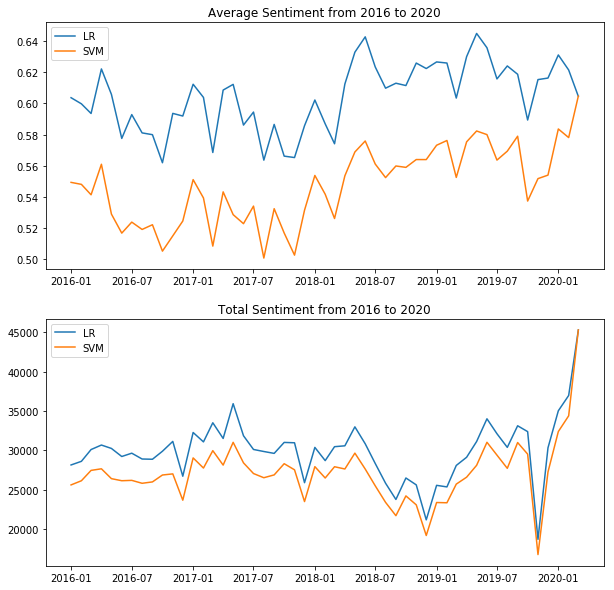

In [12]:
dates = get_dates()
means = np.load("mean.npy")
summation = np.load("summation.npy")
svm_means = np.load("svm-mean.npy")
svm_summation = np.load("svm-summation.npy")

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title("Average Sentiment from 2016 to 2020")
plt.plot(dates[:-1], means[:-1], label="LR")
plt.plot(dates[:-1], svm_means[:-1], label="SVM")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Total Sentiment from 2016 to 2020")
plt.plot(dates[:-1], summation[:-1], label="LR")
plt.plot(dates[:-1], svm_summation[:-1], label="SVM")
plt.legend()


## NER Bar Chart
### Preparing The top appearing Entities in a month with optional conditions i.e. (Section, Entity type)

In [31]:
def filter_names(names_list, remove_flag=True):
    ''' Filter Names (Remove entites with same last name problem) '''
    removed = ['Donald Trump', 'Trump', 'Reuters', 'U.S.', 'US', 'the United States']
    output = []
    names = []
    names_list = names_list[::-1]
    for name in names_list:
        match = process.extractOne(name[0], names)
        if not match or match[1] < 65:
            if (not remove_flag) or (remove_flag and name[0] not in removed):
                output.append(name)
                names.append(name[0])
    return np.array(output)[::-1]
            
def top_entities(year=2020, month=3, day=None, section=None, entity_type=None, count=15):
    global df, flags
    # To Avoid Reading the same dataframe every month
    if not flags[year-2016]: 
        print("reading year =", year)
        df = pd.read_csv(f"data/news-{year}.csv")
        flags[year-2016] = True
        
    print("Reading month =", month)
    df_cur = df[df['month'] == month]
    
    if section:
        df_cur = df_cur[df_cur['section'].isin(section)]
    if day:
        df_cur = df_cur[df_dur['day'] == day]
        
    ner = df_cur['ner']
    
    ner_list = ner.tolist()
    ner_list = list(map(eval, ner_list))
    combined = list(itertools.chain.from_iterable(ner_list))
    if entity_type:
        combined = [combined[i] for i in range(len(combined)) if combined[i][1] == entity_type]
    
    inside_count = 50
    counter = np.array(Counter(combined).most_common(inside_count))
    flattened = np.array([(counter[i][0][0], counter[i][0][1], counter[i][1])
                          for i in range(counter.shape[0]-1,-1,-1)])
    filtered = filter_names(flattened, remove_flag=removed_flag)[-count:]
    return flattened, filtered

### Visualizing Bar Chart

reading year = 2016
Reading month = 1
Reading month = 1
Reading month = 2
Reading month = 3
Reading month = 4
Reading month = 5
Reading month = 6
Reading month = 7
Reading month = 8
Reading month = 9
Reading month = 10
Reading month = 11
Reading month = 12
reading year = 2017


/Users/ahmedtawfik/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py:1192: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  self._draw_frame(framedata)


Reading month = 1
Reading month = 2
Reading month = 3
Reading month = 4
Reading month = 5
Reading month = 6
Reading month = 7
Reading month = 8
Reading month = 9
Reading month = 10
Reading month = 11
Reading month = 12
reading year = 2018
Reading month = 1
Reading month = 2
Reading month = 3
Reading month = 4
Reading month = 5
Reading month = 6
Reading month = 7
Reading month = 8
Reading month = 9
Reading month = 10
Reading month = 11
Reading month = 12
reading year = 2019
Reading month = 1
Reading month = 2
Reading month = 3
Reading month = 4
Reading month = 5
Reading month = 6
Reading month = 7
Reading month = 8
Reading month = 9
Reading month = 10
Reading month = 11
Reading month = 12
reading year = 2020
Reading month = 1
Reading month = 2
Reading month = 3
Reading month = 1


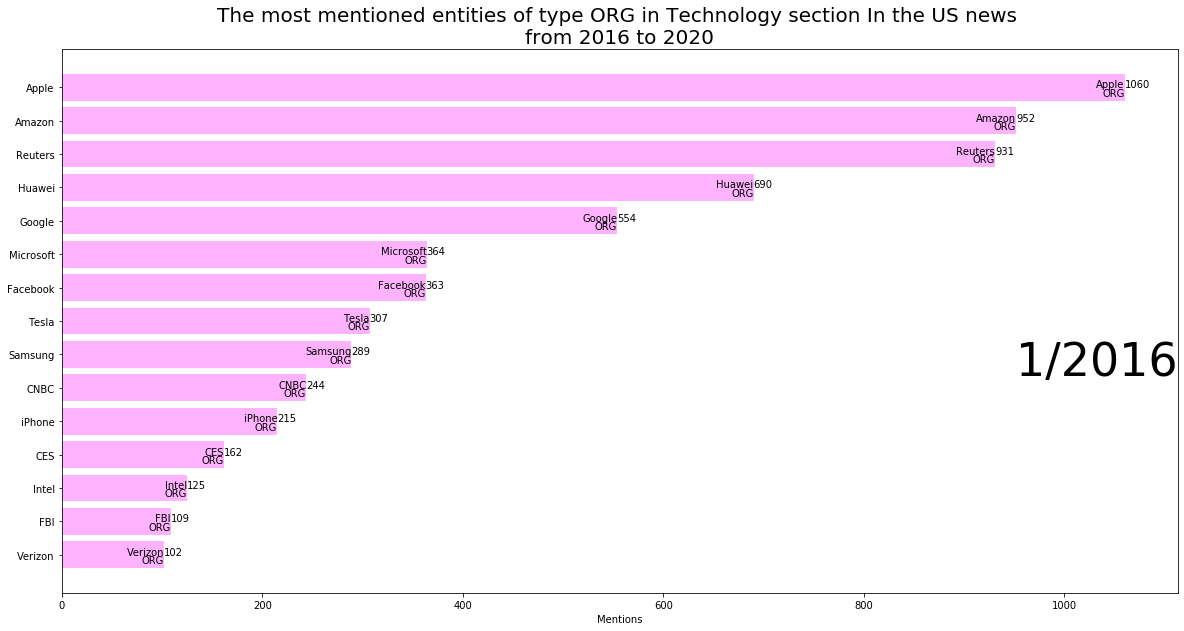

In [45]:
def draw_barchart(date_index):
    date = get_dates()[date_index]
    year = date.year
    month = date.month
    _, counter = top_entities(year, month, entity_type=entity_type, section=section_list, count=15)
    # Parsing to Numbers
    counts = [int(c) for c in counter[:,2]]
    ax.clear()
    ax.barh(counter[:,0], counts, color=[colors[counter[:,1][i]] for i in range(counter.shape[0])])
    for i in range(counter.shape[0]):
        ax.text(counts[i], i, counter[i][0], ha='right')  # Tokyo: name
        ax.text(counts[i], i-.25, counter[i][1], ha='right')  # Asia: group name
        ax.text(counts[i], i, counts[i], ha='left')   # 38194.2: value
    
    header = 'The most mentioned entities'
    if entity_type:
        header += ' of type ' + entity_type
    if section_list:
        header += f' in {section} section'

    header += ' In the US news \nfrom 2016 to 2020'
    
    ax.set_title(header, fontsize=20)
    ax.text(1, 0.4, str(month)+'/'+str(year), transform=ax.transAxes, size=46, ha='right')
    ax.set_xlabel('Mentions')
    
colors = {'PERSON': '#adb0ff', 'ORG':'#ffb3ff', 'GPE':'#90d595', 'NORP':'#e48381'
         ,'FAC':'#aafbff', 'LOC':'#f7bb5f', 'EVENT':'#eee0b1', 'PRODUCT':'#eafb50',
         'WORK_OF_ART':'#5f9bf7'}

section = 'Technology'
section_list = None
if section == 'Technology':
    section_list = ['Tech', 'Tech by VICE', 'Technology News']
elif section == 'Health':
    section_list = ['Health']
elif section == 'Sports':
    section_list = ['Sports', 'Sports News']


entity_type = 'ORG'
# entity_type = 'PERSON'
# entity_type = 'GPE'
# entity_type = 'EVENT'
# entity_type = 'PRODUCT'
# entity_type = None
flags = [False for i in range(5)]
removed_flag = False
fig, ax = plt.subplots(figsize=(20, 10))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0, 51))
animator.save(f'Outputs/animation-{entity_type}-{section}-{removed_flag}.mp4', bitrate=3000, fps=2)
# HTML(animator.to_jshtml())

## Word Cloud

reading year = 2019
Reading month = 5
[['the White House' 'ORG' '3323']
 ['London' 'GPE' '3545']
 ['India' 'GPE' '3720']
 ['British' 'NORP' '3722']
 ['EU' 'ORG' '3935']
 ['White House' 'ORG' '3989']
 ['Mexico' 'GPE' '4047']
 ['California' 'GPE' '4051']
 ['Russian' 'NORP' '4242']
 ['Americans' 'NORP' '4262']
 ['European' 'NORP' '4282']
 ['Beijing' 'GPE' '4320']
 ['K Street' 'FAC' '4332']
 ['Japan' 'GPE' '4448']
 ['Britain' 'GPE' '4516']
 ['Instagram' 'NORP' '4557']
 ['Europe' 'LOC' '4729']
 ['Apple' 'ORG' '4759']
 ['Trump' 'LOC' '4829']
 ['News Communications, Inc.' 'ORG' '4830']
 ['Capitol Hill Publishing Corp.' 'ORG' '4830']
 ['America' 'GPE' '4849']
 ['Facebook' 'ORG' '4909']
 ['Amazon' 'ORG' '5263']
 ['Republicans' 'NORP' '5389']
 ['Russia' 'GPE' '5882']
 ['Google' 'ORG' '5993']
 ['Barr' 'PERSON' '6233']
 ['CNN' 'ORG' '6374']
 ['Republican' 'NORP' '6470']
 ['Donald Trump' 'PERSON' '6740']
 ['Senate' 'ORG' '6761']
 ['Huawei' 'ORG' '7059']
 ['New York' 'GPE' '7145']
 ['House' 'ORG' '7

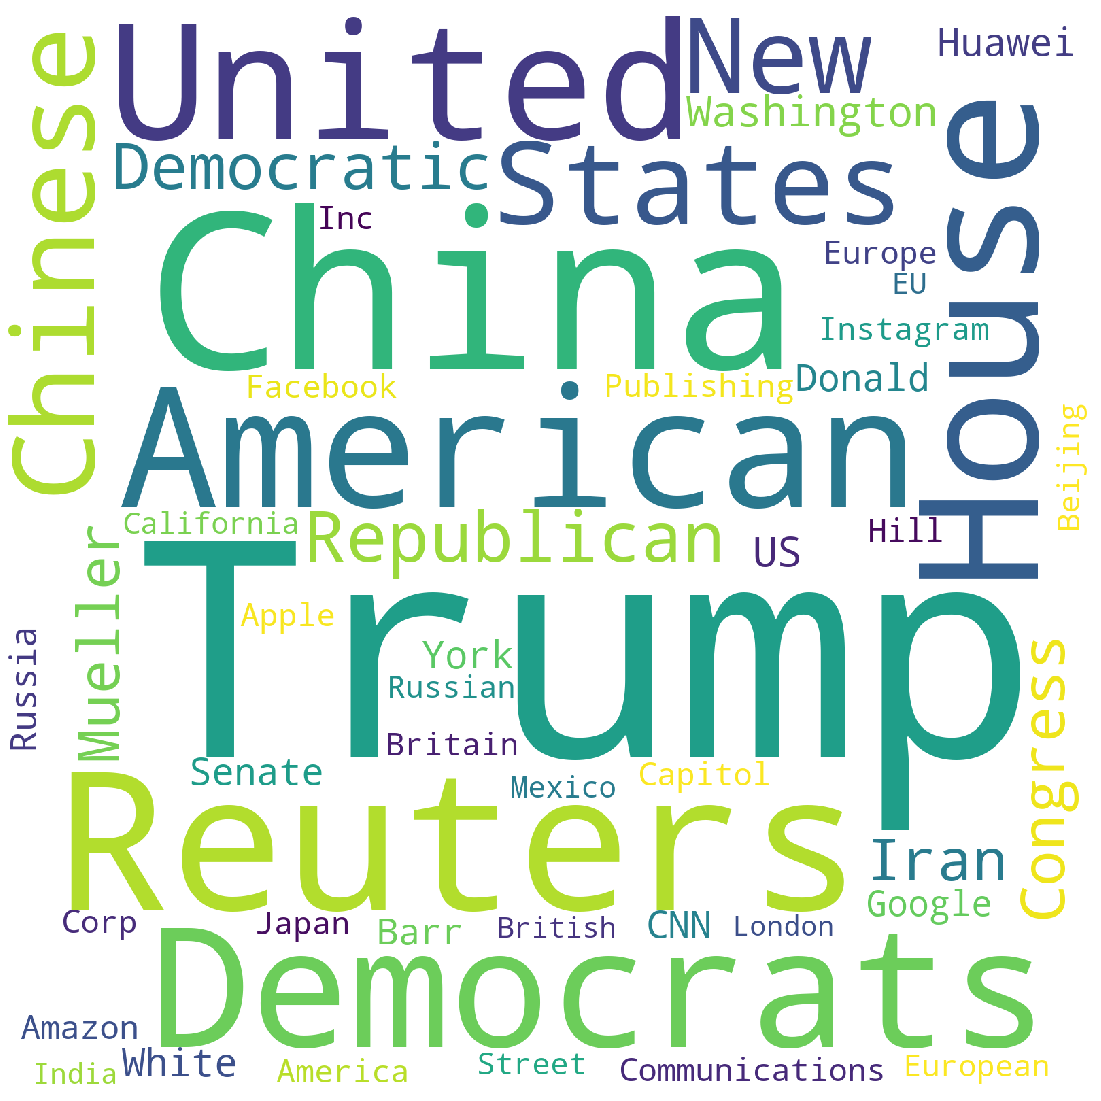

In [30]:
def word_cloud(date_index):
    date = get_dates()[date_index]
    year = date.year
    month = date.month
    counter, _ = top_entities(year, month, entity_type=None, section=None, count=30)
    print(counter)
    text = ''
    for c in counter:
        text += int(c[2])*(c[0]+' ') + ' '
    wordcloud = WordCloud(width = 1600, height = 1600, 
                background_color ='white', 
                min_font_size = 10,
                collocations = False).generate(text) 
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.imshow(wordcloud)
  
word_cloud(40)